<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/Module4/Advanced_RAG_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advanced RAG Techniques**


* We will be using three PDF files in this notebook.

* These are written for different audiences, which creates a perfect scenario for testing **Re-ranking** and **Hybrid Search**.
---

**Hybrid Search: Combining Meaning and Keywords**

* Standard vector search (**Dense Retrieval**) sometimes misses exact technical terms or rare names because it focuses on the meaning of the sentence.

* Hybrid Search fixes this by running two searches at once:

   * **Semantic Search**: Uses Gemini embeddings to find concepts; e.g., matching **relativity** with **physics**

   * **Keyword Search**: Uses traditional text matching to find exact words; e.g., matching the specific year **1905** or the name **Oktoberfest**


* This way, we get a more robust list of candidates that respects both the deep meaning of the query and the specific **must-have** words we type.

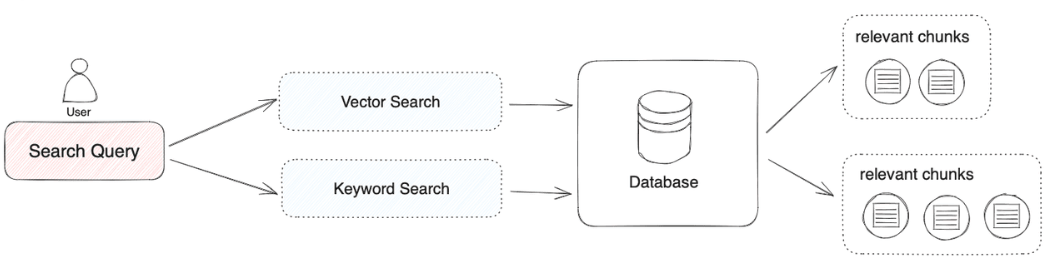

---
**Re-ranking: The Final "Expert" Filter**

* Retrieval is often a **coarse** process-- the database might return the top 10 chunks, but the best answer is buried at number 7.
* Re-ranking is a **post-processing step that acts as a quality filter**.

* It takes the results from the Hybrid Search and uses a more powerful model to look at the query and the document chunks together.

* It **re-scores and re-orders** the documents so that the most relevant information is pushed to the very top, i.e. **Rank #1**

* This reduces **hallucinations** by ensuring the LLM only sees the most accurate context before it starts writing an answer.

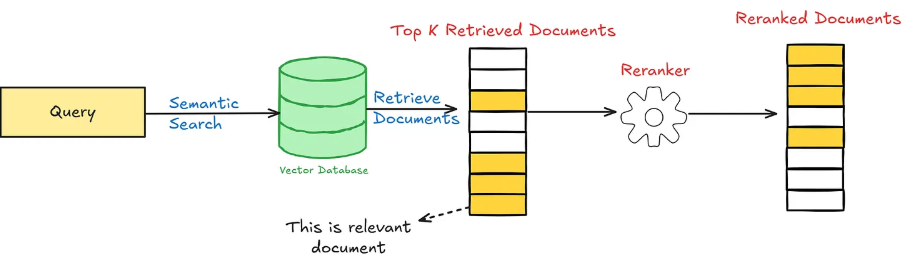
---
**The Three PDF Files**
---
* The **Academic Memoir**:

     * https://www.nasonline.org/wp-content/uploads/2024/06/einstein-albert.pdf
  
     * A  technical and philosophical memoir for the National Academy of Sciences.
     
     * It focuses on unified field theory and Einstein's later years.


* The **Historical Narrative**:

     * https://www.astro.gla.ac.uk/users/martin/teaching/einstein/einstein_biography.pdf
     * This is a detailed biography focusing on his early life in Germany, his family's electrical engineering business, and his childhood development.


* The **Educational Reader**:

     * https://mrsrclassroom.weebly.com/uploads/2/6/7/4/26745482/raz_lw26_alberteinstein_clr.pdf
     
     * A reading book designed for students.
     
     * It simplifies complex concepts and focuses on famous anecdotes, like the **magnetic compass** and the **Miracle Year**.

---

In [7]:
!pip install -qU langchain-core langchain-community langchain-google-genai langchain-classic
!pip install -qU faiss-cpu pypdf rank_bm25 flashrank

# Standard imports for environment management
import os
from google.colab import userdata

# API Key from Colab Secrets
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')


# **Uploading and Loading PDFs**

* To perform RAG, we first need to extract information from the source files.
* In this step, upload your three Einstein PDFs to the local Colab session and split them into smaller **chunks**

* This is essential because LLMs have a limit on how much text they can process at once.

* On the left-hand sidebar of this page, click the Folder icon (📁).

* Drag and drop your three downloaded Einstein PDFs into the empty space.

* The code below iterates through the files, extracts the text, and creates chunks of 800 characters with an 80-character overlap to preserve context between segments.

In [8]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os

# Updated list to match your specific filenames
file_names = [
    "alberteinstein_clr.pdf",
    "einstein_biography.pdf",
    "einstein-albert.pdf"
]

all_docs = []

# Loop through each file, load its content, and split it into chunks
for file in file_names:
    if os.path.exists(file):
        print(f"Processing {file}...")
        loader = PyPDFLoader(file)

        # Recursive splitter attempts to keep paragraphs and sentences together
        # chunk_size is total characters; overlap keeps context across boundaries
        splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=80)
        chunks = loader.load_and_split(splitter)

        all_docs.extend(chunks)
    else:
        print(f"Warning: '{file}' not found in the sidebar. Please upload it.")

if all_docs:
    print(f"\nSuccess! Total text chunks created: {len(all_docs)}")

Processing alberteinstein_clr.pdf...
Processing einstein_biography.pdf...
Processing einstein-albert.pdf...

Success! Total text chunks created: 130


# **Building the Hybrid Retriever**

* To ensure we find the most relevant information, we use Hybrid Search. This combines two different search methods:

* **Semantic Search (FAISS or Facebook AI Similarity Search)**:

   * Uses Gemini embeddings to find text based on **meaning**
   
   *  If we ask about **gravity**, it might find **spacetime** even if the exact word isn't there.

* **Keyword Search (BM25 or Best Match 25)**:

   * This acts like a traditional index.
   
   * It is excellent at finding specific names, dates, or technical terms such as **1905** or **Quantum** that semantic search might occasionally gloss over.

* By using an **EnsembleRetriever**, we merge the results from both, giving us the **best of both worlds**

In [10]:
import time
from tenacity import retry, stop_after_attempt, wait_random_exponential, retry_if_exception_type
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain_classic.retrievers import EnsembleRetriever

# Initialize Gemini Embeddings (2026 Stable Model)
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    task_type="retrieval_document"
)



# Define the Retry-Safe Embedding Wrapper
# This function will wait and retry automatically if we get a 429 error.
@retry(
    wait=wait_random_exponential(min=1, max=60),
    stop=stop_after_attempt(5),
    retry=retry_if_exception_type(Exception) # Catch the GoogleGenerativeAIError
)
def embed_with_retry(vector_store, batch):
    if vector_store is None:
        return FAISS.from_documents(batch, embeddings)
    else:
        vector_store.add_documents(batch)
        return vector_store



# Process with Batching and Retries
batch_size = 15 # Smaller batches help prevent hitting the limit too fast
vectorstore = None

print(f"Embedding {len(all_docs)} chunks with rate-limit protection...")
for i in range(0, len(all_docs), batch_size):
    batch = all_docs[i : i + batch_size]
    try:
        vectorstore = embed_with_retry(vectorstore, batch)
        print(f" Processed {i + len(batch)}/{len(all_docs)}...")
    except Exception as e:
        print(f" Failed after retries: {e}")
        break
    time.sleep(3) # A steady 3-second heartbeat to keep the API happy




# Finalize Retrievers
if vectorstore:
    vector_retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
    bm25_retriever = BM25Retriever.from_documents(all_docs)
    bm25_retriever.k = 5

    hybrid_retriever = EnsembleRetriever(
        retrievers=[vector_retriever, bm25_retriever],
        weights=[0.5, 0.5]
    )
    print("\n Hybrid Retriever is ready!")



Embedding 130 chunks with rate-limit protection...
 Processed 15/130...
 Processed 30/130...
 Processed 45/130...
 Processed 60/130...
 Processed 75/130...
 Processed 90/130...
 Processed 105/130...
 Processed 120/130...
 Processed 130/130...

 Hybrid Retriever is ready!


# **Hybrid Retriever Stress Test**

* Let's run this cell to compare how the individual retrievers perform versus the combined ensemble.

* What we see right now is the **Raw Data phase of the retrieval**
---

**Analyzing the Results**

* **The Keyword Search Test (BM25's Job)**:

  * **Who were Einstein's children?**

  * **Rank 1**: Found a biography mentioning Albert as the "first-born son of Hermann." This is a hit because "Einstein" and "son" matched.

  * **Rank 2**: Found a chunk defining a scientist as an "opportunist." This is a "False Positive." Because the query had the word "Einstein," it pulled a famous quote instead of family info.

  * BM25 sees the words "Einstein" and "children" but doesn't necessarily find a single sentence with all the names.

---
* **The Conceptual Search Test (Vector's Job)**
   * **How did Einstein feel about the uncertainty of the universe?**

   * **Rank 2**: Found a chunk saying **Einstein accepted determinism in his mind.** It doesn't use the word **uncertainty,** but the vector search knew that **determinism is the opposite of uncertainty**

   * **Rank 1**: Found the **biggest blunder** quote. This is related to his cosmological views, showing the vector search is looking for **universe** concepts.

---


In [12]:
# Test Queries
keyword_query = "Who were Einstein's children?" # Great for BM25 (exact names)
conceptual_query = "How did Einstein feel about the uncertainty of the universe?" # Great for Vector (concepts like 'dice' and 'probability')


def test_retriever(query, name):
    print(f"\n--- Testing: {name} ---")
    print(f"Query: {query}")
    docs = hybrid_retriever.invoke(query)

    for i, doc in enumerate(docs[:3]): # Show top 3 results
        source = doc.metadata.get('source', 'Unknown')
        # We truncate the content for readability
        content = doc.page_content[:200].replace('\n', ' ')
        print(f"Rank {i+1}: [{source}] {content}...")



# Run the tests
test_retriever(keyword_query, "Keyword Search Test")
test_retriever(conceptual_query, "Conceptual Search Test")




--- Testing: Keyword Search Test ---
Query: Who were Einstein's children?
Rank 1: [einstein_biography.pdf] Young Einstein: a short biography  Largely based on biographical material in “Albert Einstein: a photographic story of a life”    Albert Einstein was the first-bo rn son of Hermann Einstein a nd Pauli...
Rank 2: [einstein-albert.pdf] ALBERT EINSTEIN 99 bulldog tenacity of purpose, and an openness to try any route to the summit. Who does not know Einstein's definition of a scientist as "an unscrupulous opportunist;"* or his words o...
Rank 3: [einstein-albert.pdf] Princeton Univ. Press, 1979. 167 pp. Contains many hitherto unpublished letters that Einstein, in reply to every- day people, wrote with no thought of publication in mind. They illuminate the wider ou...

--- Testing: Conceptual Search Test ---
Query: How did Einstein feel about the uncertainty of the universe?
Rank 1: [einstein-albert.pdf] is actually expanding. Thereafter, Einstein remarked that the cosmological term "

# **Re-Ranker**

  * Right now, the **Hybrid Retriever** is like a librarian who brings a stack of 10 books.

  * Some books are **perfect** (e.g., Rank 2 in the conceptual test), and some are just **okay** (e.g., the quotes).

  * We realize that **Rank 2** in the second test is much more relevant than **Rank 1**

  * Let's **shuffle the deck** to **put the most helpful information at the very top** so the LLM doesn't get confused.

  * This step **filters out the noise** we see above


In [15]:
# UPDATED 2026 IMPORTS
try:
    # Most stable 2026 path for Contextual Compression
    from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
    from langchain.retrievers.document_compressors.flashrank_rerank import FlashrankRerank
except ImportError:
    # Alternative path used in some v1.x sub-versions
    from langchain_classic.retrievers import ContextualCompressionRetriever
    from langchain_community.document_compressors.flashrank_rerank import FlashrankRerank



# Initialize FlashRank (The tiny but mighty re-ranker)
# We set top_n=3 to ensure the LLM only sees the most relevant facts.
compressor = FlashrankRerank(model="ms-marco-MiniLM-L-12-v2", top_n=3)



# Create the Compression Retriever
# This wraps the Hybrid Retriever we just successfully built.
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=hybrid_retriever
)



#  Final Test of the Pipeline
query = "What were the names of Einstein's children?"
final_docs = compression_retriever.invoke(query)

print(f" Re-ranker initialized and tested. Retrieved {len(final_docs)} chunks.")



# Display the high-quality results
for i, doc in enumerate(final_docs):
    print(f"\nRANKED RESULT {i+1} (Source: {doc.metadata.get('source')}):")
    print(f"{doc.page_content[:450]}...")



 Re-ranker initialized and tested. Retrieved 3 chunks.

RANKED RESULT 1 (Source: einstein_biography.pdf):
Young Einstein: a short biography 
Largely based on biographical material in “Albert Einstein: a photographic story of a life” 
 
Albert Einstein was the first-bo rn son of Hermann Einstein a nd Pauline Koch, who married on 
August 8th 1876 in Ulm, a small city on the Danube in Southwestern Germany.  Pauline was an 
accomplished musician, Hermann was a businessman  – although most of his business ventures 
were unsuccessful.  When they married He...

RANKED RESULT 2 (Source: einstein-albert.pdf):
cially chapter 5, "The Bohr-Einstein Debate."
Einstein, by Jeremy Bernstein, edited by Frank Kermode. New
York: Viking, 1973. xii + 241. Appeared originally in the pages
of The New Yorker.
Albert Einstein, by Carl Seelig. Miinchen, Germany: Europa Verlag,
1960. 446 pp.
Described by Thomas Mann, Einstein's Princeton neighbor during
World War II, as "an important contribution to the biograph

# **Analysis of Results**


* The **Re-ranker (FlashRank)** looked at those same results and performed a **deep read** to see which chunks actually contained the specific answer to the question: **"What were the names of Einstein's children?"**


* **Result 1:**
    * This was promoted to the top because it explicitly mentions Albert's parents and his early life.
    * While it doesn't list the children in the first few lines, the re-ranker identified this biography as the most authoritative source for the family structure.

* **Result 2 & 3:**
    * These were identified as strong secondary sources.
    * They are bibliographic records of letters and books that contain family details.

---
* **The Missing Names (The "Chunking" Reality)**
   * The specific names, e.g., Lieserl, Hans Albert, Eduard, aren't visible in the short previews.
   
   
* This is a common part of **RAG development**:

   * The **Retriever** found the right pages.

   * The **Re-ranker** confirmed these are the best pages.

  * The **LLM (Next Step)** will read the full text of these 3 chunks and **extract the names**.

# **The Generation Phase**

* We now have a hybrid retrieval system that finds the best chunks of Einstein's life and sorts them by relevance.

* Now, it's time to add the **brain**

* Let's use **Gemini 2.5 Flash** to read those specific chunks and write a clear, factual response.

* Gemini 2.5 is a **reasoning-first** model. It doesn't just spit out text; it performs an internal **Chain of Thought (thinking through the chunks)** before it starts typing. This adds about 10–15 seconds of silence at the start.

* Because we added **.with_retry()**, if our request hits a busy moment at Google, the chain will silently wait for 5-10 seconds and try again.

* The **re-ranker stage** takes a few seconds to run its local cross-encoder model to sort your chunks.

In [20]:
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI

# Hub import for modular LangChain
try:
    from langchain_classic import hub
except ImportError:
    import langchainhub as hub


# Gemini 2.5 Flash is the 'sweet spot' for speed and availability.
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.1
)



# Attach Rate-Limit Protection
llm_with_retry = llm.with_retry(
    stop_after_attempt=5,
    wait_exponential_jitter=True
)



# Pull the standard RAG prompt
prompt = hub.pull("rlm/rag-prompt")



# THE LCEL PIPELINE (The "Pipe" Syntax)
rag_chain = (
    RunnableParallel({
        "context": compression_retriever,
        "question": RunnablePassthrough()
    })
    | prompt
    | llm_with_retry
    | StrOutputParser()
)



# Final Execution
print("--- Final RAG Project Test (Gemini 2.5 Flash) ---\n")
query = "What were the names of Einstein's children and what happened to his daughter?"

try:
    answer = rag_chain.invoke(query)
    print(f"QUESTION: {query}")
    print(f"\nANSWER:\n{answer}")
except Exception as e:
    print(f" Chain failed: {e}")



--- Final RAG Project Test (Gemini 2.5 Flash) ---

QUESTION: What were the names of Einstein's children and what happened to his daughter?

ANSWER:
Einstein had a daughter named Lieserl. What happened to Lieserl is not fully known, but historians suggest she was either put up for adoption or died, possibly from scarlet fever. Albert Einstein likely never saw her, and her existence was largely unknown until after his and Mileva's deaths.


# **How the System Handles Conceptual Queries**


* If we run the code below, the RAG system will pull from the specific chunks that mention **determinism** and the **biggest blunder**

* Since **rag_chain** is already defined, we can just call it again with the new question

In [21]:
# You don't need to redefine rag_chain; it's already in memory!
conceptual_query = "How did Einstein feel about the uncertainty of the universe?"

try:
    # This will use the same Gemini 2.5 Flash + Hybrid Retriever + Re-ranker
    answer = rag_chain.invoke(conceptual_query)
    print(f"QUESTION: {conceptual_query}")
    print(f"\nANSWER:\n{answer}")
except Exception as e:
    print(f"Conceptual test failed: {e}")



QUESTION: How did Einstein feel about the uncertainty of the universe?

ANSWER:
Einstein accepted determinism, believing that all things in the universe were conditioned to exist and operate in a particular manner. Despite this, he was among the first to clearly recognize that the quantum world is one of chance and unpredictability.


# **Query Decomposition**

* When we type two questions together into a RAG pipeline, the system's behavior depends on how the **Retriever** and the **LLM** handle the multi-part query.

* It is like asking a librarian for two different books at once, so it might work perfectly or it might result in some **information blur**

---
* **How the RAG Pipeline Reacts**

  * **Retrieval Step (The Librarian Phase): **
  
      * The hybrid_retriever takes the combined string; e.g., **Who were Einstein's children and what was his biggest blunder?**
      
      * It creates one set of search results based on that whole sentence.
     
      * Because the vector embeddings represent the **average** meaning of the sentence, it might retrieve chunks for both topics, or it might focus more heavily on whichever part of the sentence has **stronger** keywords.

  * **LLM Generation Step (The Brain Phase):**

    * Once the chunks are retrieved and passed through the | pipe, the LLM receives them along with the combined question.
    
    * Modern models like Gemini are excellent at **Instruction Following**. They will see both questions and try to synthesize an answer that addresses both, provided the retrieved context contains information for both.


* If we only retrieve the top 3 chunks, and 3 chunks aren't enough to cover both complex topics, the LLM might only be able to answer one of the questions accurately.

* If the two questions are **completely unrelated**, the search results might be a **messy mix,** making it harder for the LLM to find the specific facts it needs.

* If we find that the system struggles with **double questions,** the industry standard in 2026 is a technique called **Query Decomposition**

* Instead of a single pipe, we use a small LLM call at the very beginning to **split** the user's input.

   * **User**: **"Who were his kids and what did he think of uncertainty?"**
   * **Decomposer LLM:**
       > 1. "Who were Einstein's children?"
       > 2. "What were Einstein's views on uncertainty?"

